In [4]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2a94098a5b5846fce031c4f34c72736ed0bef8bdf8b712d9e371c2050c0477c4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm
import seaborn as sns  

In [3]:
from IPython.display import clear_output

In [4]:
train_dir = '/kaggle/input/resampled-aml-dataset/Resampled_AML_Images/train'
test_dir = '/kaggle/input/resampled-aml-dataset/Resampled_AML_Images/test'

# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

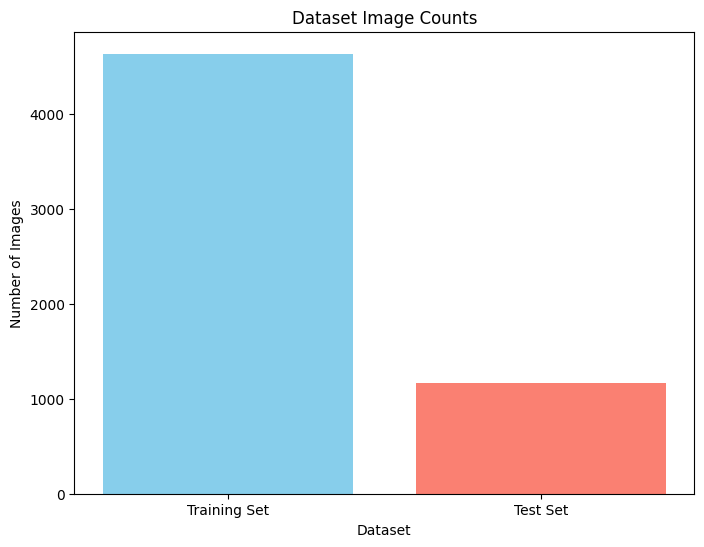

In [6]:
train_count = len(train_dataset)
test_count = len(test_dataset)

# Dataset labels and counts
dataset_names = ['Training Set', 'Test Set']
dataset_counts = [train_count, test_count]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(dataset_names, dataset_counts, color=['skyblue', 'salmon'])
plt.title('Dataset Image Counts')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()


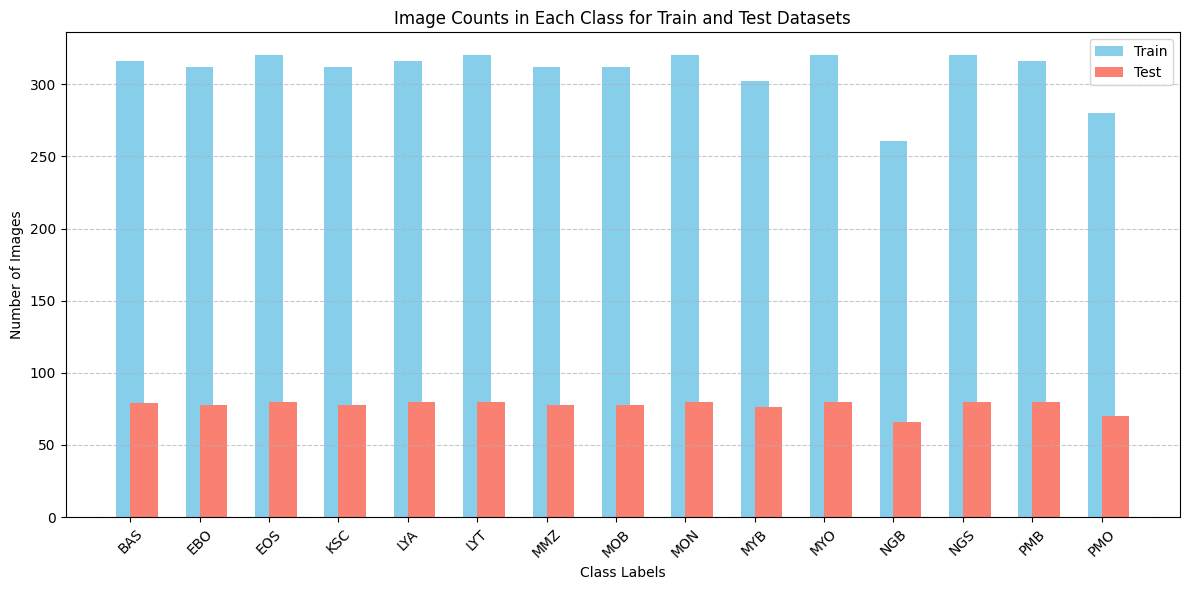

In [7]:
# Function to count images in each subfolder
def count_images_in_folders(root_dir):
    counts = {}
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            counts[folder] = len(os.listdir(folder_path))  # Count images in each subfolder
    return counts

# Get counts for train and test folders
train_counts = count_images_in_folders(train_dir)
test_counts = count_images_in_folders(test_dir)

# Sorting labels alphabetically
labels = sorted(train_counts.keys())
train_values = [train_counts[label] for label in labels]
test_values = [test_counts[label] for label in labels]

# Plotting
x = range(len(labels))  # Position of bars on x-axis

plt.figure(figsize=(12, 6))
plt.bar(x, train_values, width=0.4, label='Train', color='skyblue', align='center')
plt.bar(x, test_values, width=0.4, label='Test', color='salmon', align='edge')

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Image Counts in Each Class for Train and Test Datasets')
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [10]:
def visualize_images(dataset, num_images=8):
    # Get a batch of training data
    inputs, labels = next(iter(DataLoader(dataset, batch_size=num_images, shuffle=True)))

    # Create a grid of images
    grid = torchvision.utils.make_grid(inputs, nrow=4)
    imshow(grid, title='Sample Training Images')

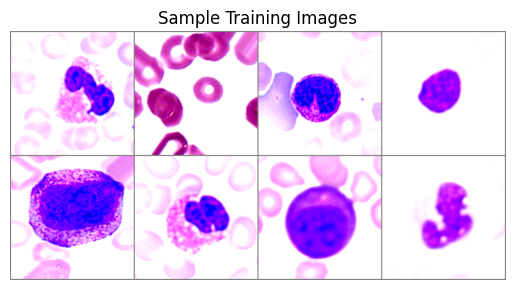

In [11]:
visualize_images(train_dataset)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Efficient-b0**

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, len(train_dataset.classes))
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 41.0MB/s]


Loaded pretrained weights for efficientnet-b0


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 10
train_accuracies = []
val_accuracies = []

In [17]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({"Batch Loss": loss.item()})
        clear_output(wait=True)
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct / total
    train_accuracies.append(epoch_accuracy)
    
    
    model.eval()  # Set model to evaluation mode
    correct_val = 0
    total_val = 0
    all_preds = []  # Initialize list for predictions
    all_labels = []  # Initialize list for true labels
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
   


Training Epoch 10: 100%|██████████| 145/145 [00:49<00:00,  2.92batch/s]


Epoch 10/10, Loss: 0.0520, Training Accuracy: 0.9834


In [30]:
max_length = max(len(all_preds), len(all_labels))
all_preds.extend([None] * (max_length - len(all_preds)))
all_labels.extend([None] * (max_length - len(all_labels)))

# Write both lists to the same CSV file line-by-line
with open("/kaggle/working/predictionsLabels.csv", "w") as f:
    f.write("Predictions,Labels\n")  # Header
    for preds, labels in zip(all_preds, all_labels):
        f.write(f"{preds},{labels}\n")

In [18]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

         BAS       1.00      0.84      0.91        79
         EBO       1.00      0.72      0.84        78
         EOS       0.79      0.99      0.88        80
         KSC       0.95      0.96      0.96        78
         LYA       1.00      0.84      0.91        80
         LYT       0.51      0.95      0.67        80
         MMZ       0.98      0.74      0.85        78
         MOB       1.00      0.62      0.76        78
         MON       0.83      0.61      0.71        80
         MYB       0.81      0.87      0.84        76
         MYO       0.58      0.86      0.70        80
         NGB       0.98      0.62      0.76        66
         NGS       0.81      0.91      0.86        80
         PMB       0.96      0.89      0.92        80
         PMO       0.80      0.87      0.84        70

    accuracy                           0.82      1163
   macro avg       0.87      0.82      0.83      1163
we

In [22]:
torch.save(model.state_dict(), '/kaggle/working/efficientNet-b0.pth')

In [29]:
print(val_accuracies)
print(train_accuracies)
max_length = max(len(train_accuracies), len(val_accuracies))
train_accuracies.extend([None] * (max_length - len(train_accuracies)))
val_accuracies.extend([None] * (max_length - len(val_accuracies)))

# Write both lists to the same CSV file line-by-line
with open("/kaggle/working/accuracies.csv", "w") as f:
    f.write("Train Accuracy,Validation Accuracy\n")  # Header
    for train, val in zip(train_accuracies, val_accuracies):
        f.write(f"{train},{val}\n")

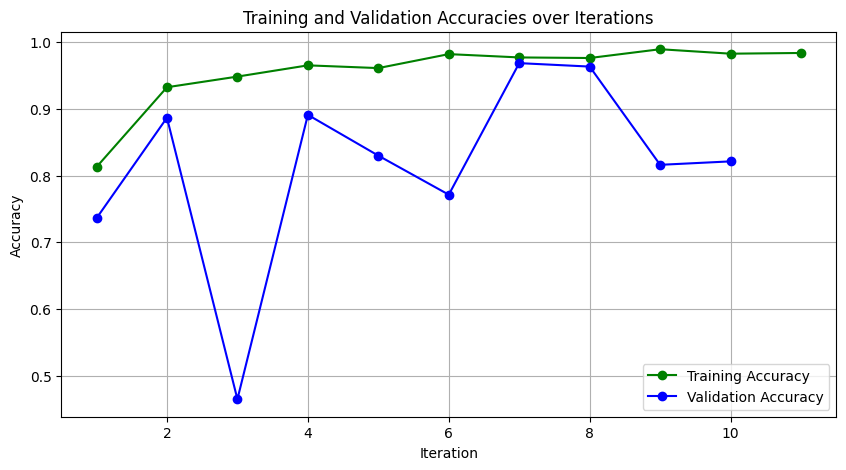

In [23]:

iterations = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_accuracies, marker='o', color='g', linestyle='-', label="Training Accuracy")
plt.plot(iterations[:len(val_accuracies)], val_accuracies, marker='o', color='b', linestyle='-', label="Validation Accuracy")
plt.title("Training and Validation Accuracies over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


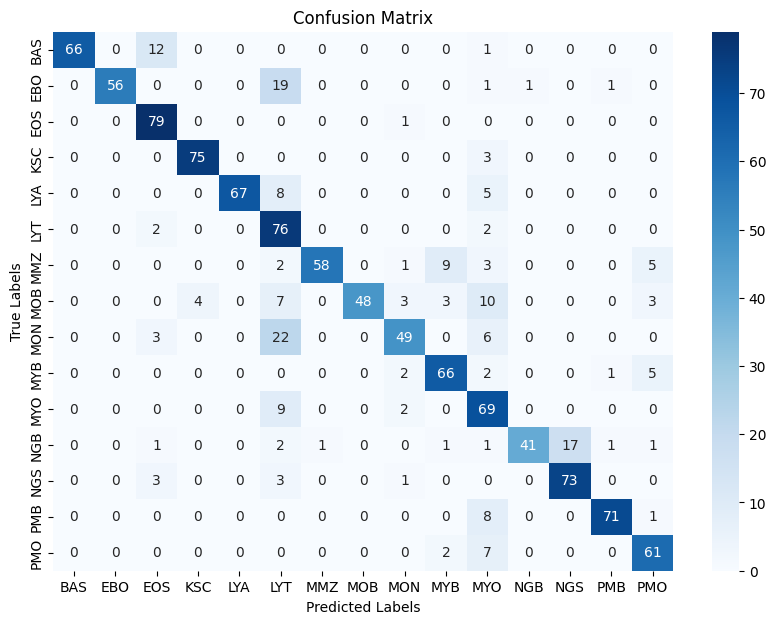

In [27]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Efficient-b1**

In [31]:
model = EfficientNet.from_pretrained('efficientnet-b1')
model._fc = nn.Linear(model._fc.in_features, len(train_dataset.classes))
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth

  0%|          | 0.00/30.1M [00:00<?, ?B/s]
  0%|          | 128k/30.1M [00:00<00:26, 1.17MB/s]
  2%|▏         | 768k/30.1M [00:00<00:08, 3.77MB/s]
 12%|█▏        | 3.75M/30.1M [00:00<00:01, 15.3MB/s]
 33%|███▎      | 10.0M/30.1M [00:00<00:00, 34.0MB/s]
 45%|████▍     | 13.5M/30.1M [00:00<00:00, 23.2MB/s]
 67%|██████▋   | 20.1M/30.1M [00:00<00:00, 26.2MB/s]
100%|██████████| 30.1M/30.1M [00:01<00:00, 26.6MB/s]


Loaded pretrained weights for efficientnet-b1


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 10
train_accuracies = []
val_accuracies = []

In [34]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({"Batch Loss": loss.item()})
        clear_output(wait=True)
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct / total
    train_accuracies.append(epoch_accuracy)
    
    
    model.eval()  # Set model to evaluation mode
    correct_val = 0
    total_val = 0
    all_preds = []  # Initialize list for predictions
    all_labels = []  # Initialize list for true labels
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
   


Training Epoch 10: 100%|██████████| 145/145 [01:01<00:00,  2.37batch/s]


Epoch 10/10, Loss: 0.0864, Training Accuracy: 0.9726


In [35]:
max_length = max(len(all_preds), len(all_labels))
all_preds.extend([None] * (max_length - len(all_preds)))
all_labels.extend([None] * (max_length - len(all_labels)))

# Write both lists to the same CSV file line-by-line
with open("/kaggle/working/predictionsLabels(b1).csv", "w") as f:
    f.write("Predictions,Labels\n")  # Header
    for preds, labels in zip(all_preds, all_labels):
        f.write(f"{preds},{labels}\n")

In [36]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

         BAS       1.00      0.65      0.78        79
         EBO       0.99      1.00      0.99        78
         EOS       1.00      0.96      0.98        80
         KSC       1.00      0.90      0.95        78
         LYA       0.85      1.00      0.92        80
         LYT       0.91      1.00      0.95        80
         MMZ       0.87      1.00      0.93        78
         MOB       1.00      0.94      0.97        78
         MON       0.92      0.88      0.90        80
         MYB       0.85      0.96      0.90        76
         MYO       0.97      0.80      0.88        80
         NGB       0.85      0.92      0.88        66
         NGS       0.91      0.99      0.95        80
         PMB       0.87      1.00      0.93        80
         PMO       0.94      0.83      0.88        70

    accuracy                           0.92      1163
   macro avg       0.93      0.92      0.92      1163
we

In [37]:
torch.save(model.state_dict(), '/kaggle/working/efficientNet-b1.pth')

In [6]:
print(val_accuracies)
print(train_accuracies)
max_length = max(len(train_accuracies), len(val_accuracies))
train_accuracies.extend([None] * (max_length - len(train_accuracies)))
val_accuracies.extend([None] * (max_length - len(val_accuracies)))

# Write both lists to the same CSV file line-by-line
with open("/kaggle/working/accuracies(b1).csv", "w") as f:
    f.write("Train Accuracy,Validation Accuracy\n")  # Header
    for train, val in zip(train_accuracies, val_accuracies):
        f.write(f"{train},{val}\n")

[0.5554600171969045, 0.827171109200344, 0.8993981083404987, 0.8882201203783319, 0.7833190025795357, 0.822871883061049, 0.944969905417025, 0.9355116079105761, 0.9269131556319863, 0.9217540842648323]
[0.7934899762879931, 0.923474886829058, 0.9480491485233886, 0.9499892218150463, 0.9644319896529424, 0.9732701013149385, 0.9775813752964001, 0.9844794136667385, 0.9842638499676655, 0.9726234102177194]


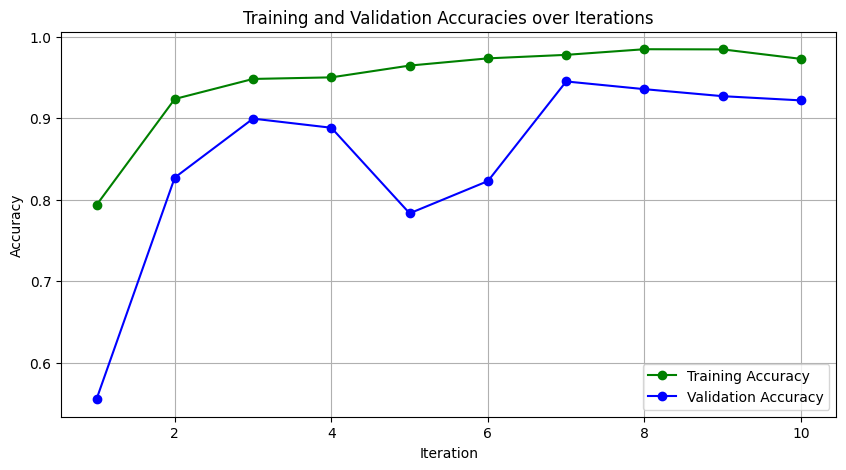

In [7]:
iterations = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_accuracies, marker='o', color='g', linestyle='-', label="Training Accuracy")
plt.plot(iterations[:len(val_accuracies)], val_accuracies, marker='o', color='b', linestyle='-', label="Validation Accuracy")
plt.title("Training and Validation Accuracies over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

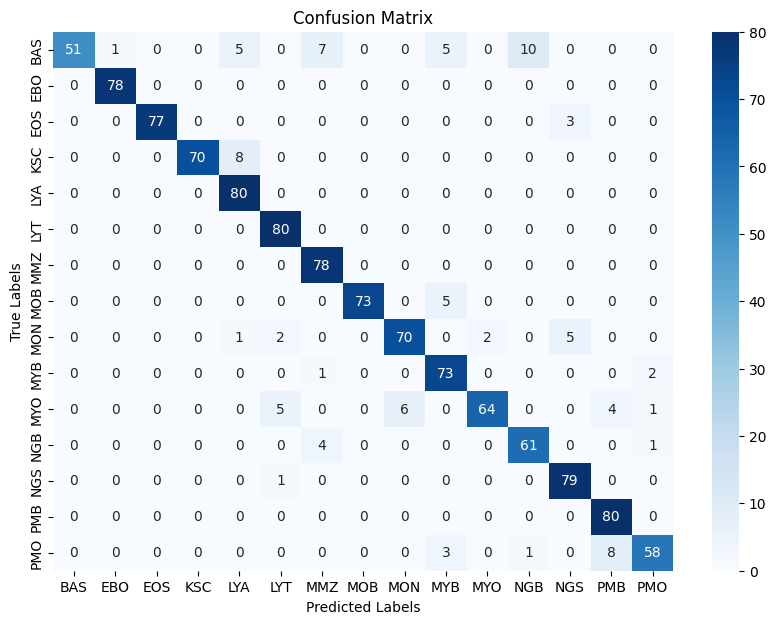

In [40]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()